In [1]:
# Importation of libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

from useful_methods.plots import plot_delaunay

In [2]:
# Importing database
df = pd.read_csv("../database/data.csv", sep=";", decimal=",")
df.head()

,code_op,nom_op,num_site,id_site_partage,id_station_anfr,x,y,latitude,longitude,nom_reg,...,site_ZB,site_DCC,site_strategique,site_capa_240mbps,date_ouverturecommerciale_5g,site_5g_700_m_hz,site_5g_800_m_hz,site_5g_1800_m_hz,site_5g_2100_m_hz,site_5g_3500_m_hz
0,20801,Orange,00000001A1,NaN,0802290015,687035.0,6985761.0,49.97028,2.81944,Hauts-de-France,...,0,0,0,0,NaN,0,0,0,0,0
1,20801,Orange,00000001B1,NaN,0642290151,422853.0,6249263.0,43.28861,-0.41389,Nouvelle-Aquitaine,...,0,0,0,1,2020-12-14,0,0,0,1,0
2,20801,Orange,00000001B2,NaN,0332290026,416932.0,6422196.0,44.84112,-0.58333,Nouvelle-Aquitaine,...,0,0,0,1,2021-02-22,0,0,0,0,1
3,20801,Orange,00000001B3,NaN,0472290005,511106.0,6349234.0,44.21666,0.63556,Nouvelle-Aquitaine,...,0,0,0,1,NaN,0,0,0,0,0
4,20801,Orange,00000001C1,NaN,0512290147,836824.0,6889450.0,49.09028,4.87333,Grand Est,...,0,0,0,1,NaN,0,0,0,0,0


In [3]:
department = "Gard"

In [4]:
df_gard = df.loc[df['nom_dep'] == department]
df_gard = df_gard.drop(columns=["code_op", "id_site_partage", "id_station_anfr", "nom_reg", "nom_dep", "insee_dep", "insee_com", "site_2g", "site_3g", "site_4g", "site_5g", "mes_4g_trim", "site_ZB", "site_DCC", "site_strategique", "site_capa_240mbps", "date_ouverturecommerciale_5g", "site_5g_700_m_hz", "site_5g_800_m_hz", "site_5g_1800_m_hz", "site_5g_2100_m_hz", "site_5g_3500_m_hz"])
df_gard.head()

,nom_op,num_site,x,y,latitude,longitude,nom_com
15,Orange,00000001J4,842967.0,6319501.0,43.96000,4.78139,Villeneuve-lès-Avignon
16,Orange,00000001K2,831610.0,6351822.0,44.25305,4.64833,Pont-Saint-Esprit
84,Orange,00000003K2,810137.0,6304429.0,43.83028,4.36917,Nîmes
351,Orange,00000010K2,817019.0,6294827.0,43.74278,4.45250,Bellegarde
391,Orange,00000011K2,801064.0,6295942.0,43.75527,4.25472,Uchaud


In [5]:
# Selecting the provider : Free Mobile
df_gard_free = df_gard.loc[df['nom_op'] == "Free Mobile"]
df_gard_free = df_gard_free.drop(columns=['nom_op'])

# Creation of points couples for Delaunay
df_gard_free_points = np.array(df_gard_free[['longitude', 'latitude']])
# Delaunay triangulation
delaunay_gard_free = Delaunay(df_gard_free_points)

In [6]:
chemin = '../local/travail_anneePrec/departements-20180101.shx'
geo_df_shx = gpd.read_file(chemin)
geo_df = geo_df_shx.drop([ 'wikipedia', 'nuts3', 'surf_km2'], axis = 1)
geo_df = geo_df.drop(geo_df[(geo_df['code_insee'] == '973') | (geo_df['code_insee'] == '972') | (geo_df['code_insee'] == '974') | (geo_df['code_insee'] == '976') | (geo_df['code_insee'] == '971')].index)
geo_df.index = geo_df.index.astype(str)

# On joint la Métropole de Lyon et le Rhône
from shapely.geometry import Polygon, MultiPolygon


# Coordonnées des polygones
polygone_rhone = geo_df[geo_df['code_insee'] == "69D"]['geometry'].values[0]
polygone_lyon = geo_df[geo_df['code_insee'] == "69M"]['geometry'].values[0]


# Créer un MultiPolygon avec les deux polygones
multipolygone_69 = polygone_rhone.union(polygone_lyon)

# Créer une nouvelle ligne avec code_insee = '69' et le MultiPolygon
dep_rhone = {
    'code_insee': '69',
    'nom': 'Rhône',
    'geometry': multipolygone_69
}
# Convertir la nouvelle ligne en GeoDataFrame
nouveau_gdf = gpd.GeoDataFrame([dep_rhone], geometry='geometry')

# Supprimer les anciennes lignes avec code_insee = '69'
geo_df = geo_df[geo_df['code_insee'] != '69D']
geo_df = geo_df[geo_df['code_insee'] != '69M']

# Ajouter la nouvelle ligne au GeoDataFrame
geo_df = gpd.GeoDataFrame(pd.concat([geo_df, nouveau_gdf], ignore_index=True), crs=geo_df.crs)

geo_df = geo_df.drop_duplicates()

# Suppression des zéros à gauche dans les numéros d'index
geo_df['code_insee'] = geo_df['code_insee'].str.lstrip('0')

/home/pmehaud/.local/lib/python3.10/site-packages/geopandas/array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [7]:
geo_df

,code_insee,nom,geometry
0,11,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
1,43,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
2,13,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
3,47,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
4,23,Creuse,"POLYGON ((1.37254 46.21672, 1.37257 46.21677, ..."
...,...,...,...
91,25,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
92,39,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
93,7,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."
94,30,Gard,"POLYGON ((3.26190 44.09335, 3.26221 44.09389, ..."


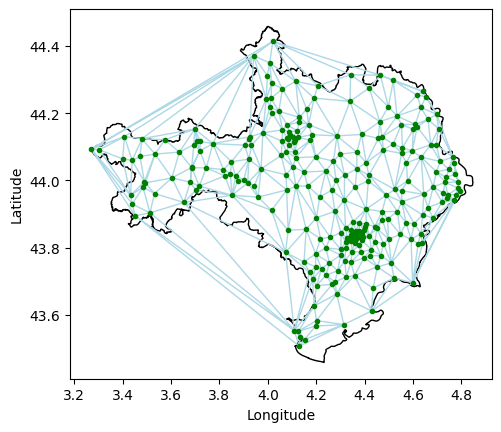

In [8]:
geo_df.loc[geo_df['nom']=="Gard",:].plot(edgecolor = "black", linewidth = 1, color="white")
plot_delaunay(delaunay_gard_free)